# Generative Adverserial Imitation Learning

Generative Adversarial Imitation Learning (GAIL) was first proposed in the paper [Generative Adversarial Imitation Learning](https://arxiv.org/abs/1606.03476) by Jonathan Ho and Stefano Ermon. 
The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

GAIL is based in the setting of reinforcement learning.
Reinforcment learning is an area of machine learning concerned with how agents take actions in an environment in order to maximize the sum of rewards.
So what a GAIL agent does is take actions in the bark environment and measure the resulting state of the agent and the world.

As the name says we are more specifically located in the setting of Imitation Learning. 
Our agent will try to learn a policy that mimics demonstrations.
We extract these demonstrations as Expert Trajectories from the interaction dataset by replaying the dataset in the bark simulator.
This gives us the expert rollouts which are a set of state action pairs representing the expert knowledge. 
In a RL setting, we need some sort of reward to update the agents network parameters.

In the GAIL approach we get the reward from an adversarial game:
Another discriminator network gets fed the agent rollouts and the experts rollouts and wants to classify between them accurately.
The agent network wants to fool the discriminator by minimizing the probability to get classified as fake.
The classification as fake or not that is output by the discriminator is the reward we feed into our agent network.
To minimize the classification as fake the agent network needs to mimic the experts demonstration and by doing so learn the experts policy.


<img width=70% src="files/data/gail_overview.gif">

## Project task

The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

### Port GAIL driver to bark
Do not reimplement gail, but use an existing implementation and bring it to bark.
We chose [TF2RL](https://github.com/keiohta/tf2rl).

### Train the GAIL agent on the Interaction Dataset
As a data source, we will use the interaction dataset: https://arxiv.org/abs/1910.03088 . Here,
w e are interested in the merging scenes: deu_merging_mt and chn_merging_zs
Have a look how the Interaction Dataset is integrated in bark: https://github.com/bark-
simulator/bark/blob/setup_tutorials/docs/tutorials/04_interaction_dataset.ipynb (NOte that
the dataset itsself is NOT enclosed with bark due to license limitations).
Train + validate agents individually for each scenes: In the first step, replace one agent and use
all other agents from the dataset: The gail agent navigates safely. Afterwards, replace more

### Evaluate the agent
Exchange the trained models on the German and the Chinese map: how well is the
generalization?
ONLY place gail agents on the map: Can we generate scenes that "look alike" the real scenarios?

## Interaction Dataset

## Expert Trajectories

## Generate Expert Trajectories

In [48]:
import os 
import bark
from pprint import pprint
from bark_ml.library_wrappers.lib_tf2rl.generate_expert_trajectories import *

tracks_folder = os.path.join(os.getcwd(), 'data')
map_file = os.path.join(os.getcwd(), 'data/DR_DEU_Merging_MT_v01_shifted.xodr')
known_key = ('DR_DEU_Merging_MT_v01_shifted', 'vehicle_tracks_013')
ego_agent = 66

param_server = create_parameter_servers_for_scenarios(map_file, tracks_folder)[known_key]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["TrackIds"] = [
    63, 64, 65, 66, 67, 68]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["StartTs"] = 232000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EndTs"] = 259000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EgoTrackId"] = ego_agent

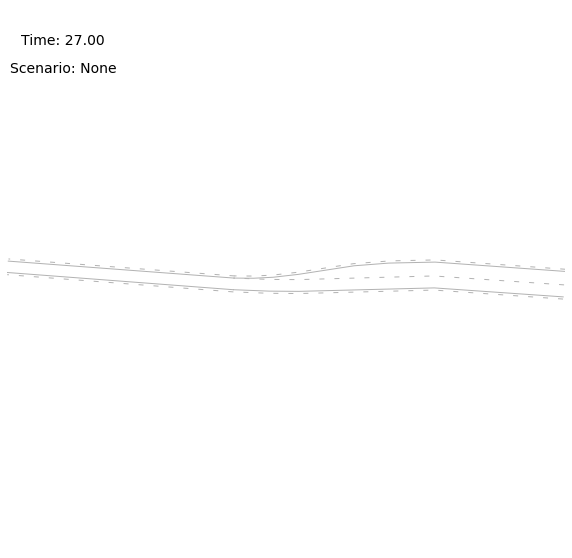

In [49]:
expert_trajectories = generate_expert_trajectories_for_scenario(param_server, sim_time_step=200, renderer="matplotlib_jupyter")

### The simulation gives us a number of observations and actions for the experts:

In [52]:
# Small number of observations for our agent
print(f'Observations for the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['obs'][:5])

Observations for the agent 66

[array([0.54990917, 0.55034685, 0.49115214, 0.02195392, 0.54979807,
       0.55021369, 0.48701411, 0.01664484, 0.55023372, 0.55031705,
       0.48717329, 0.01795783, 0.55020285, 0.55017918, 0.48908314,
       0.01927594]),
 array([0.5498873 , 0.5503481 , 0.49115214, 0.02188459, 0.54978162,
       0.55021507, 0.48701411, 0.0162844 , 0.5502159 , 0.55031848,
       0.48733243, 0.01776604, 0.55018389, 0.55018038, 0.48940146,
       0.0182608 ]),
 array([0.54986548, 0.55034935, 0.49099299, 0.02179474, 0.54976547,
       0.55021638, 0.48685497, 0.01594391, 0.55019826, 0.55031985,
       0.48733243, 0.01757585, 0.55016589, 0.55018145, 0.4895606 ,
       0.0172271 ]),
 array([0.54984373, 0.55035061, 0.49099299, 0.02165496, 0.54974967,
       0.55021775, 0.48685497, 0.01561338, 0.55018073, 0.55032122,
       0.48733243, 0.01744546, 0.55014902, 0.55018252, 0.48971975,
       0.01617412]),
 array([0.54982221, 0.55035186, 0.49083385, 0.02145529, 0.54973418,
       0.

In [53]:
# Small number of actions for our agent
print(f'Actions of the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['act'][:5])

Actions of the agent 66

[[0.0, -0.0003466568835577833],
 [-0.004201827340902073, -0.00030657489373432596],
 [0.002051691485158719, -0.00035168134700955115],
 [-0.004200119214675828, -0.0005815505374677107],
 [0.002049979741333098, -0.0009188447324507322]]


## TF2RL

## GAIL implementation

## Visual results

## Benchmark

## Summary

## Team